In [227]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets 
from scipy.spatial import ConvexHull




In [228]:
data=datasets.load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names) 
df['Target'] = pd.DataFrame(data.target) 

In [229]:


# for i in range(df['Target'].value_counts().values):
#     bucket = df[df['Target'] == i]
#     bucket = bucket.iloc[:,[0, 1]].values
#     if(len(bucket) == 0):
#         continue
#     print(bucket)


In [230]:
def comp(p1, p2):
    # komparasi 2 titik p1<p2 jika abis1<absis2, 
    # jika absisnya sama periksa ordinat11 < ordinat2
    x1, y1 = p1
    x2, y2 = p2
    if(np.abs(x1-x2)<=1e-9):
        return y1<y2
    else:
        return x1<x2

In [231]:
def minmax(points, iter, key = comp):
    # mencari ekstrem dari sekumpulan titik
    # iter adalah indeks subset titik yang dipilih dari points
    # key adalah pembanding ekstrem
    if(len(iter)):
        mn = points[iter[0]]
        mx = points[iter[0]]
        idmn = iter[0]
        idmx = iter[0]
        for i in iter:
            if(key(points[i], mn)):
                mn = points[i]
                idmn = i
            if(key(mx, points[i])):
                mx = points[i]
                idmx = i
        return idmn, idmx


In [232]:
def classifyRegion(point, p1, p2):
    # mencari region dari point relatif 
    # terhadap segmen p1p2
    x1, y1 = p1
    x2, y2 = p2
    xt, yt = point
    # buat persamaan garis ay = bx + c
    a = x2-x1
    b = y2-y1
    c = (x2-x1)*y1 - (y2-y1)*x1
    # 1 is above
    # 0 is in the line
    # -1 is below
    if(np.abs(a*yt-b*xt-c)<1e-9):
        return 0
    if(a*yt > b*xt + c):
        return 1
    else:
        return -1


In [233]:
def getDist(point, p1, p2):
    # mencari jarak point 
    # relatif terhadap segmen p1p2
    x1, y1 = p1
    x2, y2 = p2
    xt, yt = point
    # buat persamaan garis ay = bx + c
    a = x2-x1
    b = y2-y1
    c = (x2-x1)*y1 - (y2-y1)*x1
    denum = np.hypot(a, b)
    num = np.abs(a*yt - b*xt - c)
    if(denum <= 1e-9):
        return 0
    return num/denum

In [234]:
def dist(pt1, pt2):
    # mencari jarak dua buah titik
    x1, y1 = pt1
    x2, y2 = pt2
    return np.hypot((x1-x2), (y1-y2))

In [235]:
def getAngel(point, p1, p2, opp):
    # mencari sudut dari p1, point, p2. 
    # opp adalah jarak point ke segmen p1p2
    hyp1 = dist(p1, point)
    hyp2 = dist(point, p2)
    if(opp/hyp1 > 1 or opp/hyp2 > 1 or opp/hyp1 < -1 or opp/hyp2 < -1):
        return None
    return np.arccos(opp/hyp1) + np.arccos(opp/hyp2)



In [236]:
def mxNode(points, iter, p1, p2):
    # mencari node dengan jarak terjauh dari 
    # segmen p1p2, jika ada dua titik yang
    # jaraknya sama, dicari titik dengan sudut
    # p1, point, p2 nya paling besar
    def comp(pt1, pt2):
        len1 = getDist(pt1, p1, p2)
        len2 = getDist(pt2, p1, p2)
        theta1 = getAngel(pt1, p1, p2, len1)
        theta2 = getAngel(pt1, p1, p2, len2)
        if(np.abs(len1-len2)<=1e-9):
            if(theta1 == None or theta2 == None):
                return p1[1] < p2[1]
            return theta1 < theta2
        else:
            return len1<len2
    _, mx = minmax(points, iter, comp)
    return mx


In [237]:
def Hull(points, iter, p1, p2, solutions):
    # pencarian convexhull setelah titik-titik
    # dibagi dua menjadi bagian atas dan bawah
    if(len(iter)):
        mx = mxNode(points, iter, points[p1], points[p2])
        solutions.remove([p1, p2])
        solutions += [[p1, mx], [mx, p2]]
        s1 = np.array([i for i in iter if classifyRegion(points[i], points[p1], points[mx])==1])
        s2 = np.array([i for i in iter if classifyRegion(points[i], points[mx], points[p2])==1])
        solutions = Hull(points, s1, p1, mx, solutions)
        solutions = Hull(points, s2, mx, p2, solutions)
    return solutions
    

In [238]:
def MyConvexHull(points):
    # membagi titik-titik menjadi atas dan bawah, kemudian 
    # masing-masing bagian akan dicari convex hullnya
    iter = [_ for _ in range(len(points))]
    mn, mx = minmax(points, iter)
    solutions = [[mn, mx], [mx, mn]]
    s1 = np.array([i for i in range(len(points)) if classifyRegion(points[i], points[mn], points[mx])==1])
    s2 = np.array([i for i in range(len(points)) if classifyRegion(points[i], points[mn], points[mx])==-1])
    solutions = Hull(points, s1, mn, mx, solutions)
    solutions = Hull(points, s2, mx, mn, solutions)
    
    return solutions


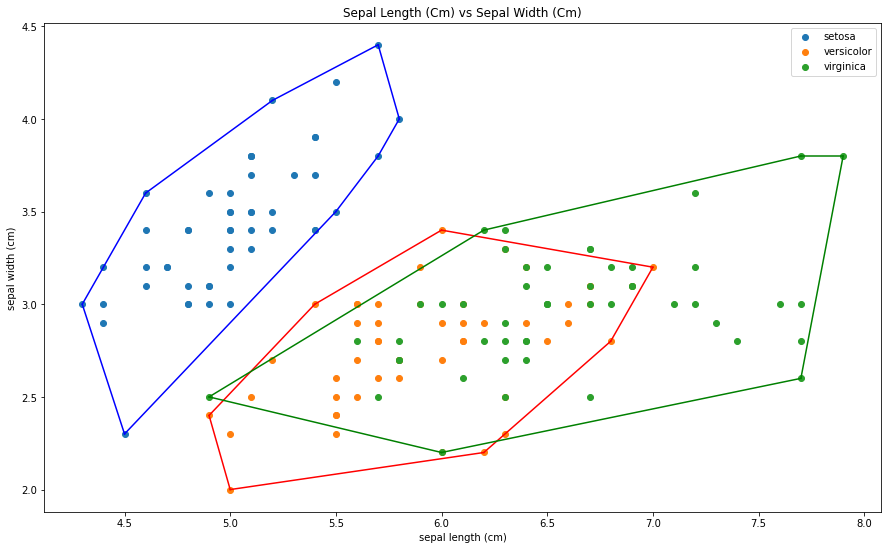

In [239]:
def plotHull(data, df, x=0, y=1):
    # menerima datasets, kemudian mengambil kolom ke-x
    # dan kolom ke-y untuk dijadikan data yang dicari 
    # convex hull-nya
    plt.figure(figsize = (15, 9))
    colors = ['blue','red','green','yellow', 'azure', 'lime', 'darkgreen', 'black', 'cyan', 'aqua','pink', 'crimson']
    plt.title(data.feature_names[x].title() + ' vs ' + data.feature_names[y].title())
    plt.xlabel(data.feature_names[x])
    plt.ylabel(data.feature_names[y])
    for i in range(len(data.target_names)):
        bucket = df[df['Target'] == i]
        bucket = bucket.iloc[:,[x, y]].values
        if(len(bucket)==0):
            continue
        hull = MyConvexHull(np.array(bucket))
        plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
        for simplex in hull:
            plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i%12])
    plt.legend()


plotHull(data, df, 0, 1)

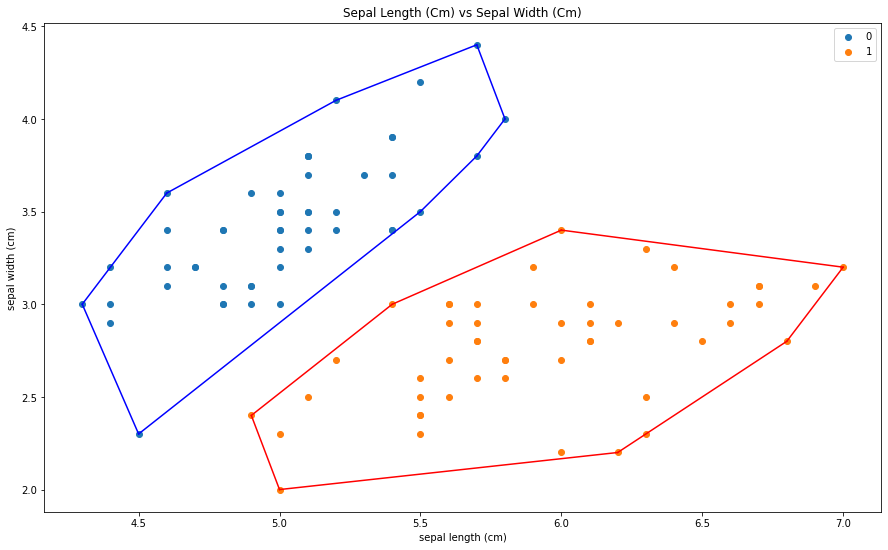

In [240]:
def plotLargeHull(data, df, x=0, y=1):
    # menampilkan convex hull dari data yang besar
    # hanya menampilkan 2 buah target
    df.dropna
    plt.figure(figsize = (15, 9))
    colors = ['blue','red','green','yellow', 'azure', 'lime', 'darkgreen', 'black', 'cyan', 'aqua','pink', 'crimson']
    plt.title(data.feature_names[x].title() + ' vs ' + data.feature_names[y].title())
    plt.xlabel(data.feature_names[x])
    plt.ylabel(data.feature_names[y])
    index = 0
    for i in df.Target.unique():
        if(index == 2):
            break
        bucket = df[df['Target'] == i]
        bucket = bucket.iloc[:,[x, y]].values
        if(len(bucket)==0):
            continue
        hull = MyConvexHull(np.array(bucket))
        plt.scatter(bucket[:, 0], bucket[:, 1], label=i)
        for simplex in hull:
            plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[index%12])
        index+=1
    plt.legend()

plotLargeHull(data, df, 0, 1)


In [241]:
def plotHull(data, df, x=0, y=1):
    # menerima datasets, kemudian mengambil kolom ke-x
    # dan kolom ke-y untuk dijadikan data yang dicari 
    # convex hull-nya
    plt.figure(figsize = (15, 9))
    colors = ['blue','red','green','yellow', 'azure', 'lime', 'darkgreen', 'black', 'cyan', 'aqua','pink', 'crimson']
    plt.title(data.feature_names[x].title() + ' vs ' + data.feature_names[y].title())
    plt.xlabel(data.feature_names[x])
    plt.ylabel(data.feature_names[y])
    index = 0
    for i in df.Target.unique():
        bucket = df[df['Target'] == i]
        bucket = bucket.iloc[:,[x, y]].values
        if(len(bucket)==0):
            continue
        hull = ConvexHull(np.array(bucket))
        plt.scatter(bucket[:, 0], bucket[:, 1], label=i)
        for simplex in hull:
            plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[index%12])
        index+=1
    plt.legend()


In [242]:
df = open("./tes.csv", "r")
print(type(df.read()))

<class 'str'>


In [243]:
Points = [[1.3,2],[2,3]]
Points = [Points[j]+[j] for j in range(len(Points))]
Points

[[1.3, 2, 0], [2, 3, 1]]

In [244]:
p = [1,2,3]
l = p[1]
l+=1
print(p)

[1, 2, 3]
